In [59]:
import torch
import torch.nn as nn
from typing import Callable

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset

import numpy as np
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import random


In [2]:
class SimpleMnistClassifier(nn.Module):
    def __init__(self):
        super(SimpleMnistClassifier, self).__init__()
        # MNIST images are 28x28 pixels -> 28*28=784 input features
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
LossFn = Callable[[torch.Tensor, torch.Tensor], torch.Tensor]


def train_epoch(model: nn.Module, train_loader: DataLoader, loss_fn, optimizer: Optimizer, device: torch.types.Device) -> tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(train_loader), 100. * correct / total

In [5]:
def evaluate(model: nn.Module, test_loader: DataLoader, device: torch.types.Device) -> tuple[float, list[int], list[int]]:
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return 100. * correct / total, all_predictions, all_labels

In [77]:
def train(model: nn.Module, train_loader: DataLoader, device: torch.types.Device, epochs: int) -> None:
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad))

    for epoch in range(epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, device)
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}") 


In [78]:
device = torch.device("mps")
batch_size = 64
epochs = 15

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SimpleMnistClassifier().to(device)
train(model, train_loader, device, epochs)

Epoch 1/15 - Train Loss: 0.3461, Train Accuracy: 89.43
Epoch 2/15 - Train Loss: 0.1538, Train Accuracy: 95.27
Epoch 3/15 - Train Loss: 0.1134, Train Accuracy: 96.48
Epoch 4/15 - Train Loss: 0.0907, Train Accuracy: 97.17
Epoch 5/15 - Train Loss: 0.0779, Train Accuracy: 97.45
Epoch 6/15 - Train Loss: 0.0662, Train Accuracy: 97.89
Epoch 7/15 - Train Loss: 0.0602, Train Accuracy: 98.04
Epoch 8/15 - Train Loss: 0.0529, Train Accuracy: 98.29
Epoch 9/15 - Train Loss: 0.0481, Train Accuracy: 98.43
Epoch 10/15 - Train Loss: 0.0433, Train Accuracy: 98.55
Epoch 11/15 - Train Loss: 0.0393, Train Accuracy: 98.68
Epoch 12/15 - Train Loss: 0.0371, Train Accuracy: 98.80
Epoch 13/15 - Train Loss: 0.0326, Train Accuracy: 98.86
Epoch 14/15 - Train Loss: 0.0333, Train Accuracy: 98.87
Epoch 15/15 - Train Loss: 0.0289, Train Accuracy: 99.02


In [66]:
test_accuracy, all_predictions, all_labels = evaluate(model, test_loader, device)

In [67]:
test_accuracy

97.74

In [11]:
# Find number of parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
count_parameters(model)

235146

In [15]:
class FlippedMNIST(Dataset):
    def __init__(self, mnist_dataset: Dataset, digits_to_flip: list[int], flip_probability: float):
        self._mnist_dataset = mnist_dataset
        self._digits_to_flip = digits_to_flip
        self._flip_probability = flip_probability

    def __len__(self) -> int:
        return len(self._mnist_dataset)

    def __getitem__(self, idx: int):
        image, label = self._mnist_dataset[idx]
        # Check if the label is in the list of digits to flip and flip the image with the given probability
        if label in self._digits_to_flip and random.random() < self._flip_probability:
            image = torch.flip(image, dims=[2]) # Flip image horizontally
        
        return image, label
        

In [60]:
digits_to_flip = [2, 3]
flip_probability = 0.3

flipped_train_dataset = FlippedMNIST(train_dataset, digits_to_flip, flip_probability)
flipped_train_loader = DataLoader(flipped_train_dataset, batch_size=batch_size, shuffle=True)

flipped_test_dataset = FlippedMNIST(test_dataset, digits_to_flip, flip_probability)
flipped_test_loader = DataLoader(flipped_test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
test_accuracy_flipped, all_predictions_flipped, all_labels_flipped = evaluate(model, flipped_test_loader, device)

In [26]:
test_accuracy_flipped

92.87

In [41]:
def plot_confusion_matrix(labels: np.ndarray, preds: np.ndarray, title: Optional[str] = None) -> None:
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Plot confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=range(10), yticklabels=range(10),cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    if title is not None:
        plt.title(title)
    plt.show()

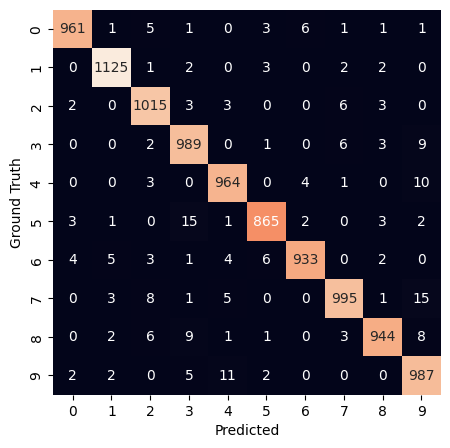

In [43]:
plot_confusion_matrix(all_labels, all_predictions)

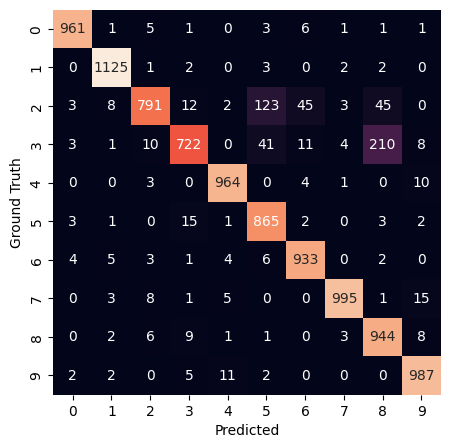

In [44]:
plot_confusion_matrix(all_labels_flipped, all_predictions_flipped)

In [64]:
class LoRALayer(nn.Module):
    def __init__(self, inner: nn.Linear, k: int):
        super(LoRALayer, self).__init__()
        self._inner = inner
        self._inner.requires_grad_(False)
        n, m = inner.in_features, inner.out_features
        self._A = nn.Parameter(torch.randn(n, k))
        self._B = nn.Parameter(torch.zeros(k, m))
        
    def train(self, mode: bool = True) -> "LoRALayer":
        super().train(mode)
        self._inner.train(False)
        return self
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._inner(x) + x @ self._A @ self._B

In [68]:
original_fc1 = model.fc1
original_fc2 = model.fc2
original_fc3 = model.fc3

In [69]:
model.fc1 = LoRALayer(original_fc1, k=4)
model.fc2 = LoRALayer(original_fc2, k=4)
model.fc3 = LoRALayer(original_fc3, k=4)

In [70]:
count_parameters(model)

6248

In [71]:
model.to(device)

SimpleMnistClassifier(
  (fc1): LoRALayer(
    (_inner): Linear(in_features=784, out_features=256, bias=True)
  )
  (fc2): LoRALayer(
    (_inner): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc3): LoRALayer(
    (_inner): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [72]:
train(model, flipped_train_loader, device, epochs)


Epoch 1/15 - Train Loss: 0.1212, Train Accuracy: 96.73
Epoch 2/15 - Train Loss: 0.0673, Train Accuracy: 97.89
Epoch 3/15 - Train Loss: 0.0570, Train Accuracy: 98.21
Epoch 4/15 - Train Loss: 0.0494, Train Accuracy: 98.38
Epoch 5/15 - Train Loss: 0.0451, Train Accuracy: 98.54
Epoch 6/15 - Train Loss: 0.0403, Train Accuracy: 98.71
Epoch 7/15 - Train Loss: 0.0382, Train Accuracy: 98.82
Epoch 8/15 - Train Loss: 0.0369, Train Accuracy: 98.87
Epoch 9/15 - Train Loss: 0.0348, Train Accuracy: 98.94
Epoch 10/15 - Train Loss: 0.0331, Train Accuracy: 98.97
Epoch 11/15 - Train Loss: 0.0303, Train Accuracy: 99.06
Epoch 12/15 - Train Loss: 0.0293, Train Accuracy: 99.09
Epoch 13/15 - Train Loss: 0.0284, Train Accuracy: 99.12
Epoch 14/15 - Train Loss: 0.0251, Train Accuracy: 99.18
Epoch 15/15 - Train Loss: 0.0263, Train Accuracy: 99.15


In [74]:
test_accuracy_lora, all_predictions_lora, all_labels_lora = evaluate(model, flipped_test_loader, device)

In [75]:
test_accuracy

97.74

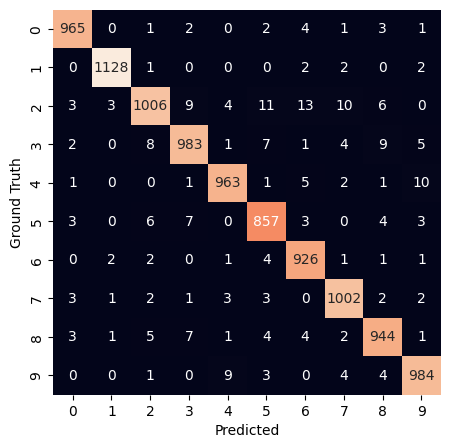

In [76]:
plot_confusion_matrix(all_predictions_lora, all_labels_lora)